[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/09_markov_chain_and_monte_carlo.ipynb)

# 9. Markov Chain Monte Carlo

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  %pip install -q watermark
  %pip install git+https://github.com/ksachdeva/rethinking-tensorflow-probability.git
except:
  pass

In [2]:
%load_ext watermark

In [3]:
from functools import partial

from jax import ops
import jax.numpy as jnp

# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

# visualization
import matplotlib.pyplot as plt

from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
from rethinking.mcmc import sample_posterior


# aliases
tfd = tfp.distributions
Root = tfd.JointDistributionCoroutine.Root


In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas,rethinking

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5
rethinking            : 0.1.0



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

# Introduction

## 9.1 Good King Markov and His island kingdom

##### Code 9.1

In [6]:
# Takes few minutes to run

num_weeks = int(1e5)
positions = np.repeat(0, num_weeks)
current = 10

coin_dist = tfd.Bernoulli(probs=0.5)
proposal_dist = tfd.Uniform(low=0.0, high=1.0)

for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    bern = coin_dist.sample().numpy()

    proposal = current + (bern * 2 - 1)

    # now make sure he loops around the archipelago
    proposal = np.where(proposal < 1, 10, proposal)
    proposal = np.where(proposal > 10, 1, proposal)

    # move?
    prob_move = proposal / current
    unif = proposal_dist.sample().numpy()
    current = np.where(unif < prob_move, proposal, current)


##### Code 9.2

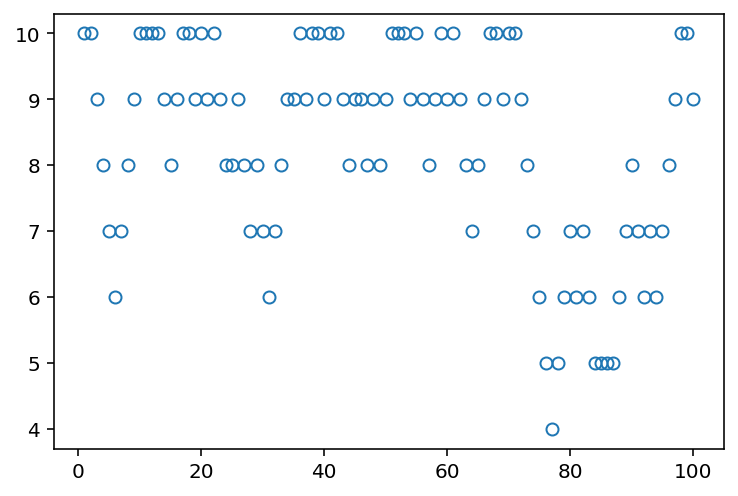

In [7]:
plt.plot(range(1, 101), positions[:100], "o", mfc="none");


##### Code 9.3

(array([ 1877.,  3575.,  5267.,  7174.,  9175., 11077., 12910., 14408.,
        16217., 18320.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <BarContainer object of 10 artists>)

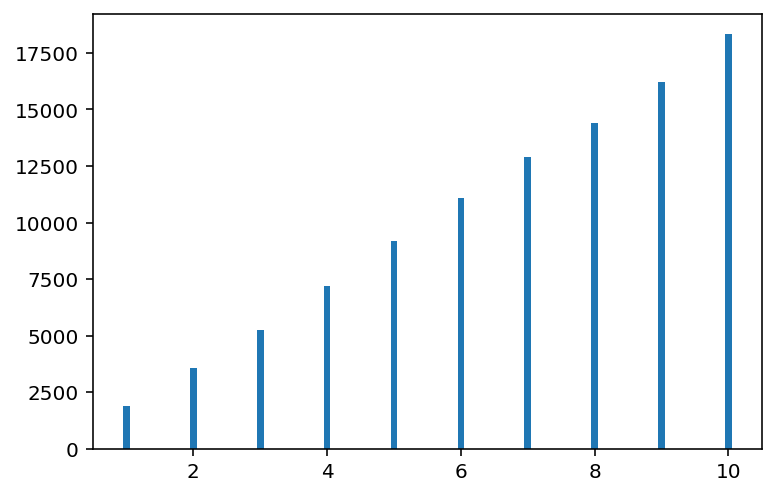

In [8]:
plt.hist(positions, bins=range(1, 12), rwidth=0.1, align="left");


In above plot, horizontal axis is the islands (and their relative populations). Vertical axis is the number of weeks that King stayed at that island

## 9.2 Metropolis Algorithms

### 9.2.1 Gibbs sampling

### 9.2.2 High-dimensional problems

##### Code 9.4


What this section demonstrates is that as the number of dimensions increase the mass of the samples move away from the peak.


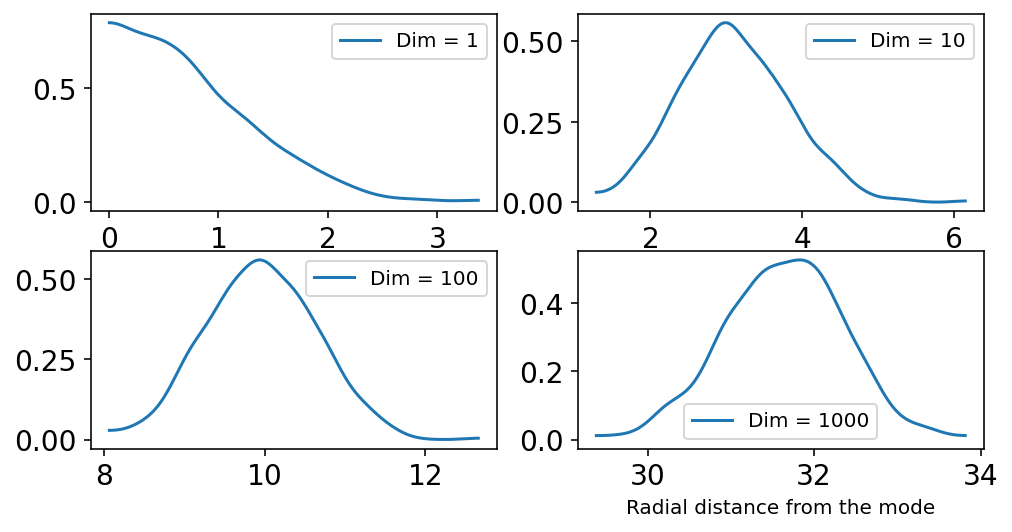

In [9]:
T = int(1e3)

_, ax = plt.subplots(2, 2, figsize=(8, 4))
plt.xlabel("Radial distance from the mode")


def build_and_plot(d, ax_p):
    loc = tf.cast(np.repeat(0, d), dtype=tf.float32)
    scale_diag = np.identity(d, dtype=np.float32)
    Y = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag).sample((T,)).numpy()
    rad_dist = lambda Y: np.sqrt(np.sum(Y ** 2))
    Rd = list(map(lambda i: rad_dist(Y[i]), np.arange(T)))
    az.plot_kde(np.array(Rd), bw=0.18, label=f"Dim = {d}", ax=ax_p)


build_and_plot(1, ax[0][0])
build_and_plot(10, ax[0][1])
build_and_plot(100, ax[1][0])
build_and_plot(1000, ax[1][1])


In the above plot, the horizontal axis shows **Radial distance** from the **mode** in the parameter space.

The peak in the above diagrams represent the amount of samples.

For Dim == 1, the peak is near 0

For Dim == 10, the peak is far from zero already 

and so on ...

The sampled points are in a thin, high-dimensional shell very far from the mode.

Because of above behavior (i.e. high dimensionsal space), the author suggests we need better MCMC algos than Metropolios and Gibbs


## 9.3 Hamiltonian Monte Carlo

##### Code 9.5

These next few cells will implement the Hamiltonian Monte Carlo algo. (Overthinking box in the chapter)

We need five things to do that -

1. A function named `U` that returns the -ive log-prob of data at a current position (parameter value)

2. A function named `grad_U` that returns the *gradient* of the -ive log-prob at the current position

3. A step size `epsilon`

4. A count of leapfrog steps `L`

5. A starting position `current_q`

Note - The position is a vector of parameter values & that the gradient also needs to return the vector of the same lenght. 


In [10]:
## Note - change from the book here
#
# The book generates the test data in code 9.6 but I am going to generate it here


def generate_test_data():
    # test data
    _SEED = 7

    seed = tfp.util.SeedStream(seed=_SEED, salt="Testdata")
    y = tfd.Normal(loc=0.0, scale=1.0).sample(50, seed=seed()).numpy()
    x = tfd.Normal(loc=0.0, scale=1.0).sample(50, seed=seed()).numpy()

    # standardize the data
    y = (y - np.mean(y)) / np.std(y)
    x = (x - np.mean(x)) / np.std(x)

    return x, y


x, y = generate_test_data()

y


array([ 0.12833239, -0.22964787, -0.40774608, -0.30924067, -0.75710726,
       -1.12151   ,  0.54429084,  0.20373885,  0.5373924 ,  2.2354805 ,
       -0.55821157,  0.8479281 , -0.01069919, -2.2879438 ,  2.1183472 ,
        0.5721366 ,  1.5381907 , -2.4450817 , -0.15067661,  0.0314163 ,
       -0.06329995, -1.5469027 ,  0.6112922 , -0.6234371 ,  0.7724736 ,
        0.31413972,  2.2127857 , -0.30521753, -0.06263847,  0.60814875,
        1.7873812 , -0.23929906, -0.1567227 , -0.09433585, -0.25074163,
        0.3817731 , -1.289493  , -0.03346271, -0.25672948, -0.02745551,
        1.6410016 , -1.2717627 , -0.18327089,  0.6673328 , -0.7348228 ,
       -0.5346852 , -1.177903  , -0.9149043 , -0.3239217 ,  0.6152883 ],
      dtype=float32)

In [11]:
def U(q, a=0.0, b=1.0, k=0.0, d=1.0):
    muy = q[0]
    mux = q[1]

    logprob_y = tf.reduce_sum(tfd.Normal(loc=muy, scale=1.0).log_prob(y)).numpy()
    logprob_x = tf.reduce_sum(tfd.Normal(loc=mux, scale=1.0).log_prob(x)).numpy()

    logprob_muy = tfd.Normal(loc=a, scale=b).log_prob(muy).numpy()
    logprob_mux = tfd.Normal(loc=k, scale=d).log_prob(mux).numpy()

    return -(logprob_y + logprob_x + logprob_muy + logprob_mux)


##### Code 9.6

In [12]:
def U_gradient(q, a=0.0, b=1.0, k=0.0, d=1.0):
    muy = q[0]
    mux = q[1]
    G1 = np.sum(y - muy) + (a - muy) / b ** 2  # dU/dmuy
    G2 = np.sum(x - mux) + (k - mux) / b ** 2  # dU/dmux
    return np.stack([-G1, -G2])  # negative bc energy is neg-log-prob


##### Code 9.7,  9.8,  9.9 & 9.10

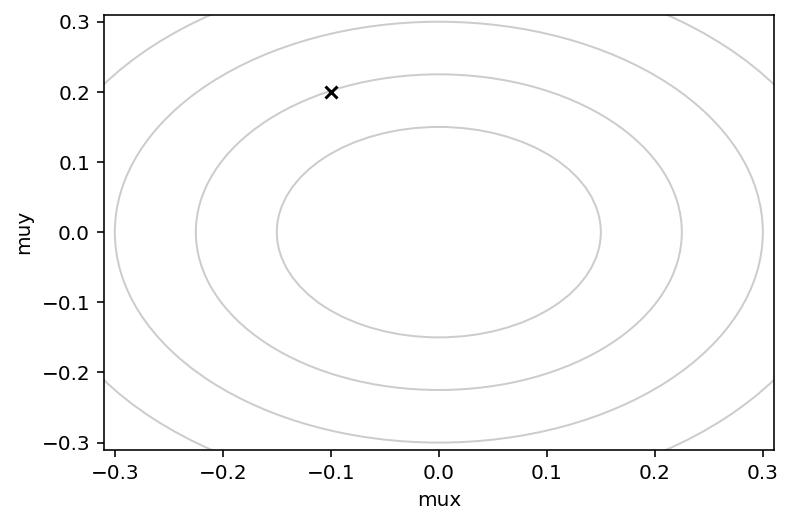

In [13]:
Q = {}
Q["q"] = np.array([-0.1, 0.2])
pr = 0.31
plt.subplot(ylabel="muy", xlabel="mux", xlim=(-pr, pr), ylim=(-pr, pr))
step = 0.03
L = 11  # 0.03/28 for U-turns --- 11 for working example
n_samples = 4
path_col = (0, 0, 0, 0.5)
for r in 0.075 * np.arange(2, 6):
    plt.gca().add_artist(plt.Circle((0, 0), r, alpha=0.2, fill=False))
plt.scatter(Q["q"][0], Q["q"][1], c="k", marker="x", zorder=4)


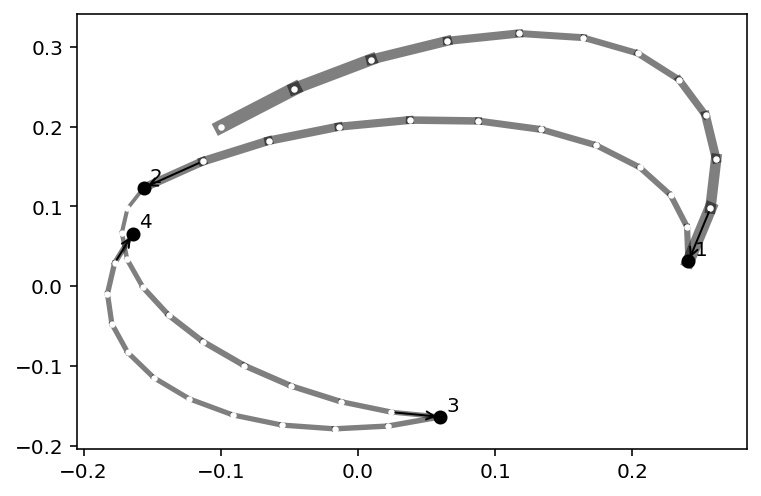

In [14]:
def HMC2(U, grad_U, epsilon, L, current_q):
    q = current_q

    # Random flick - p is the momentum
    p = tfd.Normal(loc=0.0, scale=1.0).sample(q.shape[0]).numpy()
    current_p = p

    # Make a half step for momentum at the begining
    p = p - epsilon * grad_U(q) / 2

    # initialize bookkeeping - saves trajectory
    qtraj = jnp.full((L + 1, q.shape[0]), np.nan)
    ptraj = qtraj

    qtraj = ops.index_update(qtraj, 0, current_q)
    ptraj = ops.index_update(ptraj, 0, p)

    # Alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            p = p - epsilon * grad_U(q)
            ptraj = ops.index_update(ptraj, i + 1, p)
        qtraj = ops.index_update(qtraj, i + 1, q)

    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2

    # ptraj[L] = p
    ptraj = ops.index_update(ptraj, L, p)

    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = np.sum(current_p ** 2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p ** 2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = tfd.Uniform(low=0.0, high=1.0).sample().numpy()
    if runif < np.exp(current_U - proposed_U + current_K - proposed_K):
        new_q = q  # accept
        accept = 1
    else:
        new_q = current_q  # reject

    return {
        "q": new_q,
        "traj": qtraj,
        "ptraj": ptraj,
        "accept": accept,
        "dH": proposed_U + proposed_K - (current_U + current_K),
    }


for i in range(n_samples):
    Q = HMC2(U, U_gradient, step, L, Q["q"])
    if n_samples < 10:
        for j in range(L):
            K0 = np.sum(Q["ptraj"][j] ** 2) / 2
            plt.plot(
                Q["traj"][j : j + 2, 0],
                Q["traj"][j : j + 2, 1],
                c=path_col,
                lw=1 + 2 * K0,
            )
        plt.scatter(Q["traj"][:, 0], Q["traj"][:, 1], c="white", s=5, zorder=3)
        # for fancy arrows
        dx = Q["traj"][L, 0] - Q["traj"][L - 1, 0]
        dy = Q["traj"][L, 1] - Q["traj"][L - 1, 1]
        d = np.sqrt(dx ** 2 + dy ** 2)
        plt.annotate(
            "",
            (Q["traj"][L - 1, 0], Q["traj"][L - 1, 1]),
            (Q["traj"][L, 0], Q["traj"][L, 1]),
            arrowprops={"arrowstyle": "<-"},
        )
        plt.annotate(
            str(i + 1),
            (Q["traj"][L, 0], Q["traj"][L, 1]),
            xytext=(3, 3),
            textcoords="offset points",
        )
    plt.scatter(
        Q["traj"][L + 1, 0],
        Q["traj"][L + 1, 1],
        c=("red" if np.abs(Q["dH"]) > 0.1 else "black"),
        zorder=4,
    )


## 9.4 Easy HMC: ulam  (TODO)

## 9.5 Care and feeding of your Markov chain (TODO)